# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-s109A Introduction to Data Science

## Lab 6 - Part 1: Olympics

**Harvard University**<br/>
**Summer 2021**<br/>
**Authors:** Kevin Rader, Shivam Raval, Chris Gumb, Pavlos Protopapas and Chris Tanner

---

In [247]:
import random
random.seed(12345)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

# Predicting Olympic Medal Counts in 2020

![](medalcount.png)

### References: 

World Bank Data: https://data.worldbank.org/indicator/

Olympic Medal Counts: https://en.wikipedia.org/wiki/2016_Summer_Olympics_medal_table

We'd like to predict the total medal count for the current 2020 olympics based on past history and some demographic data (really, just population and per capita GDP).  Let's firs tread in the data and do some quick EDA:

### 1. Load the datasets

In [248]:
# Read in the data
medals00 = pd.read_csv('data/medals2000.csv', encoding = "ISO-8859-1")
medals04 = pd.read_csv('data/medals2004.csv', encoding = "ISO-8859-1")
medals08 = pd.read_csv('data/medals2008.csv', encoding = "ISO-8859-1")
medals12 = pd.read_csv('data/medals2012.csv', encoding = "ISO-8859-1")
medals16 = pd.read_csv('data/medals2016.csv', encoding = "ISO-8859-1")

gdp = pd.read_csv('data/gdp_per_capita.csv')
pop = pd.read_csv('data/population.csv')

medals00.head()

,country,code,gold,silver,bronze,total
0,YugoslaviaÊ,YUG,1,1,1,3
1,VietnamÊ,VIE,0,1,0,1
2,UruguayÊ,URU,0,1,0,1
3,Trinidad and TobagoÊ,TRI,0,1,1,2
4,ThailandÊ,THA,1,0,2,3


Let's do some simple EDA teating `total` medals in 2016 as the response:

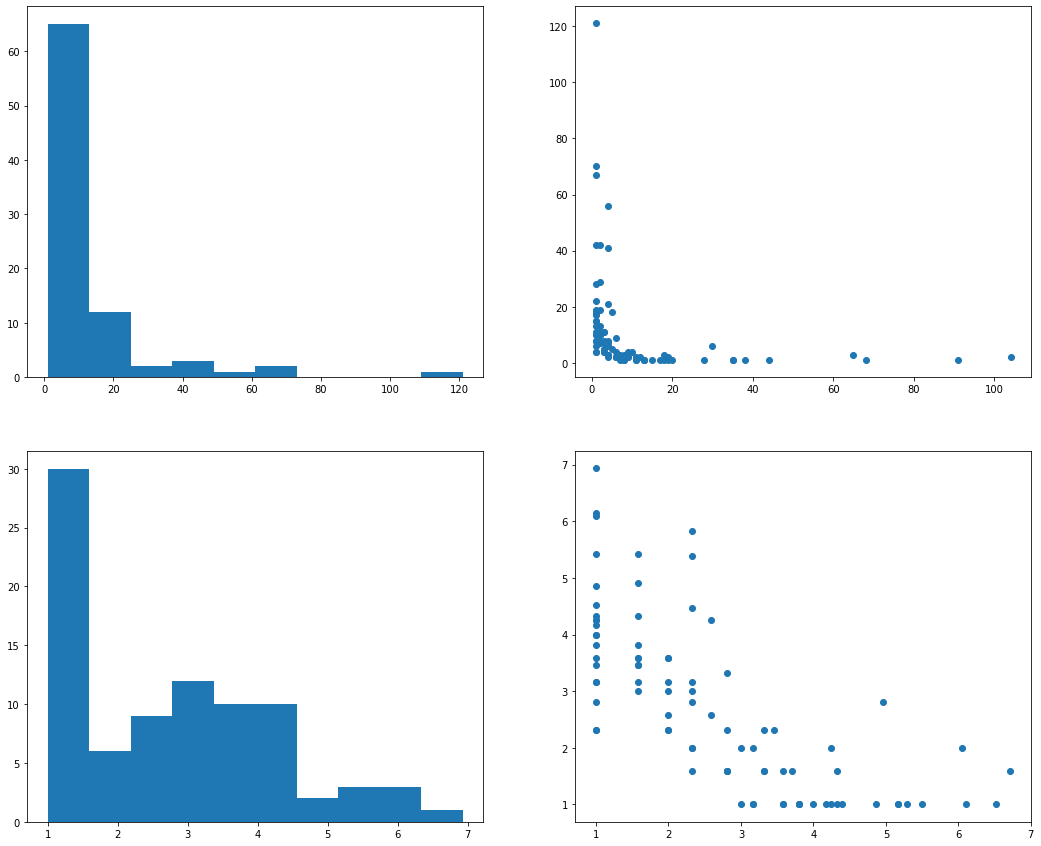

In [249]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,15))

ax[0][0].hist(medals16['total'])
ax[0][1].scatter(medals12['total'],medals16['total'])
ax[1][0].hist(np.log2(medals16['total']+1))
ax[1][1].scatter(np.log2(medals12['total']+1),np.log2(medals16['total']+1))
plt.show()


Wait what, a negative correlation!?!?!?!?  What's going on?  Let's check one thing

In [250]:
medals16.head()


,country,code,gold,silver,bronze,total
0,United StatesÊ,USA,46,37,38,121
1,Great BritainÊ,GBR,27,23,17,67
2,ChinaÊ,CHN,26,18,26,70
3,RussiaÊ,RUS,19,17,20,56
4,GermanyÊ,GER,17,10,15,42


In [251]:
medals12.head()

,country,code,gold,silver,bronze,total
0,VietnamÊ,VIE,0,0,1,1
1,VenezuelaÊ,VEN,1,0,0,1
2,UgandaÊ,UGA,1,0,0,1
3,Trinidad and TobagoÊ,TRI,1,1,2,4
4,TajikistanÊ,TJK,0,0,1,1


That explains it!  So we need to carefully [merge](), and then explore:

In [252]:
medals = medals16.merge(medals12,on="code",how="outer")
medals.columns = medals.columns.str.replace("_x","16").str.replace("_y","12")
medals.head()

,country16,code,gold16,silver16,bronze16,total16,country12,gold12,silver12,bronze12,total12
0,United StatesÊ,USA,46.0,37.0,38.0,121.0,United StatesÊ,46.0,28.0,30.0,104.0
1,Great BritainÊ,GBR,27.0,23.0,17.0,67.0,Great BritainÊ,29.0,17.0,19.0,65.0
2,ChinaÊ,CHN,26.0,18.0,26.0,70.0,ChinaÊ,38.0,31.0,22.0,91.0
3,RussiaÊ,RUS,19.0,17.0,20.0,56.0,RussiaÊ,20.0,20.0,28.0,68.0
4,GermanyÊ,GER,17.0,10.0,15.0,42.0,GermanyÊ,11.0,20.0,13.0,44.0


/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


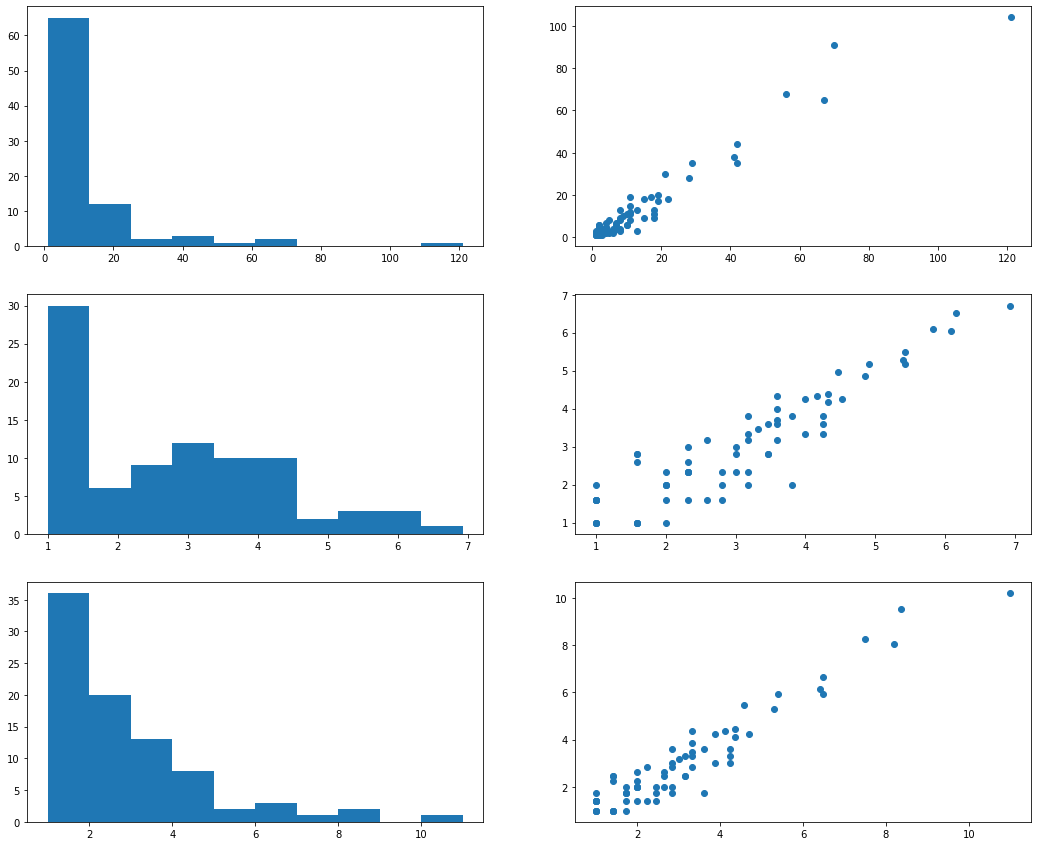

In [253]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,15))

ax[0][0].hist(medals['total16'])
ax[0][1].scatter(medals['total16'],medals['total12'])
ax[1][0].hist(np.log2(medals['total16']+1))
ax[1][1].scatter(np.log2(medals['total16']+1),np.log2(medals['total12']+1))
ax[2][0].hist(np.sqrt(medals['total16']))
ax[2][1].scatter(np.sqrt(medals['total16']),np.sqrt(medals['total12']))
plt.show()



Now that looks much better.  But what are the warning signs for?!?!?  Let's check one thing:

In [254]:
medals.tail()

,country16,code,gold16,silver16,bronze16,total16,country12,gold12,silver12,bronze12,total12
94,NaN,GAB,NaN,NaN,NaN,NaN,GabonÊ,0.0,1.0,0.0,1.0
95,NaN,CYP,NaN,NaN,NaN,NaN,CyprusÊ,0.0,1.0,0.0,1.0
96,NaN,CMR,NaN,NaN,NaN,NaN,CameroonÊ,0.0,0.0,1.0,1.0
97,NaN,AFG,NaN,NaN,NaN,NaN,AfghanistanÊ,0.0,0.0,1.0,1.0
98,NaN,BOT,NaN,NaN,NaN,NaN,BotswanaÊ,0.0,1.0,0.0,1.0


OK there's missingness!  But this is sytematic :)

Note: this happened because of the way we merged.  We used `outer` join which takes the union of the two data set and fills in `NaN`s where they are missing.  If we used `inner`, then it would have taken the intersection (but would drop the observations that do not show up in the other data set...not the ideal here.

**Q1.1** What values should we impute into this data set for `total16` and `total12`?  What about for `country`? Using `pd.fillna` [docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) to accomplish the task.  Be careful: order of operations matter!

*your answer here*

In [255]:
#######
# your code here
#######

medals['country16'] = medals['country16'].fillna(medals['country12'])
medals['country12'] = medals['country12'].fillna(medals['country16'])
medals = medals.fillna(0)
medals.tail()

,country16,code,gold16,silver16,bronze16,total16,country12,gold12,silver12,bronze12,total12
94,GabonÊ,GAB,0.0,0.0,0.0,0.0,GabonÊ,0.0,1.0,0.0,1.0
95,CyprusÊ,CYP,0.0,0.0,0.0,0.0,CyprusÊ,0.0,1.0,0.0,1.0
96,CameroonÊ,CMR,0.0,0.0,0.0,0.0,CameroonÊ,0.0,0.0,1.0,1.0
97,AfghanistanÊ,AFG,0.0,0.0,0.0,0.0,AfghanistanÊ,0.0,0.0,1.0,1.0
98,BotswanaÊ,BOT,0.0,0.0,0.0,0.0,BotswanaÊ,0.0,1.0,0.0,1.0


**Q1.2** Fit a model (`lm1`) to predict total medal count in 2016 from total medal count in 2012.  Address the following:

- Print out the coefficients and $R^2$
- Interpret the coefficients carefully
- Investigate the assumptions
- Investigate how well Brazil ('BRA') and England ('GBR') are predicted.  Think: why are we checking these two countries?

Intercept = 0.5061599200875264 , Slope(s) = [0.96134392]
R-sq = 0.9429564732678207
Brazil: yhat =  16.849006643517416 , resid = 2.1509933564825836
England: yhat =  62.99351503908416 , resid = 4.0064849609158415


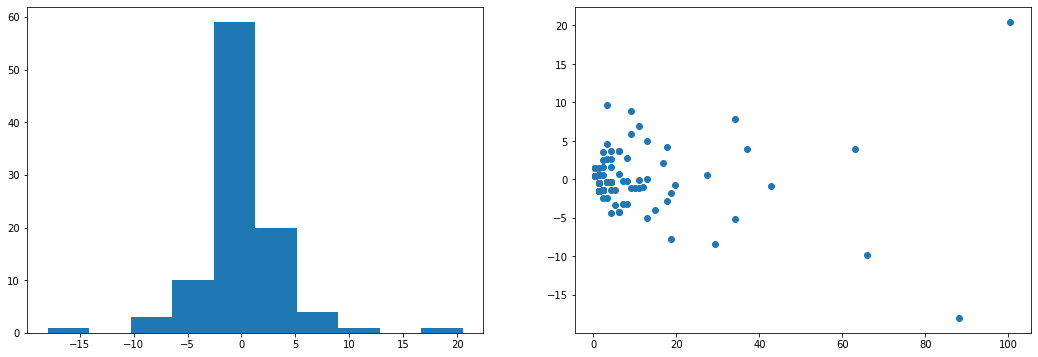

In [256]:
#######
# your code here
#######
from sklearn.linear_model import LinearRegression

lm1 = LinearRegression().fit(medals[['total12']], medals['total16'])
print("Intercept =",lm1.intercept_,", Slope(s) =",lm1.coef_)
print("R-sq =",lm1.score(medals[['total12']], medals['total16']))

yhats = lm1.predict(medals[['total12']])
resids = medals['total16'] - yhats

print("Brazil: yhat = ", yhats[medals.code=='BRA'][0], ", resid =", resids[medals.code=='BRA'].iloc[0])
print("England: yhat = ", yhats[medals.code=='GBR'][0], ", resid =", resids[medals.code=='GBR'].iloc[0])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

ax[0].hist(resids)
ax[1].scatter(yhats,resids)
plt.show()




*your answer here*

**Q1.3** Incorporate total medals from 2008 as a second predictor and fir a second model (`lm2`).  Address the following:

- Print out the coefficients and $R^2$
- Interpret the coefficients carefully and compare to `lm1`

Note: you'll have to do some processing first.

In [257]:
medals_raw = medals.copy()
medals = medals.merge(medals08,on="code",how="outer")
medals.columns=medals.columns[:-5].append(medals.columns[-5:]+"08")
medals.head()

,country16,code,gold16,silver16,bronze16,total16,country12,gold12,silver12,bronze12,total12,country08,gold08,silver08,bronze08,total08
0,United StatesÊ,USA,46.0,37.0,38.0,121.0,United StatesÊ,46.0,28.0,30.0,104.0,United StatesÊ,36.0,39.0,37.0,112.0
1,Great BritainÊ,GBR,27.0,23.0,17.0,67.0,Great BritainÊ,29.0,17.0,19.0,65.0,Great BritainÊ,19.0,13.0,19.0,51.0
2,ChinaÊ,CHN,26.0,18.0,26.0,70.0,ChinaÊ,38.0,31.0,22.0,91.0,ChinaÊ,48.0,22.0,30.0,100.0
3,RussiaÊ,RUS,19.0,17.0,20.0,56.0,RussiaÊ,20.0,20.0,28.0,68.0,RussiaÊ,24.0,13.0,23.0,60.0
4,GermanyÊ,GER,17.0,10.0,15.0,42.0,GermanyÊ,11.0,20.0,13.0,44.0,GermanyÊ,16.0,11.0,14.0,41.0


In [258]:
medals['country08'] = medals['country08'].fillna(medals['country12'])
medals = medals.fillna(0)
medals.tail()

,country16,code,gold16,silver16,bronze16,total16,country12,gold12,silver12,bronze12,total12,country08,gold08,silver08,bronze08,total08
105,0,KGZ,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,KyrgyzstanÊ,0.0,1.0,2.0,3.0
106,0,ISL,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,IcelandÊ,0.0,1.0,0.0,1.0
107,0,ECU,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,EcuadorÊ,0.0,1.0,0.0,1.0
108,0,CHI,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,ChileÊ,0.0,1.0,0.0,1.0
109,0,ZIM,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,ZimbabweÊ,1.0,3.0,0.0,4.0


In [259]:
#######
# your code here
#######

lm2 = LinearRegression().fit(medals[['total12','total08']], medals['total16'])
print("Intercept =",lm2.intercept_,", Slope(s) =",lm2.coef_)
print("R-sq =",lm2.score(medals[['total12','total08']], medals['total16']))



Intercept = 0.4417519287215672 , Slope(s) = [ 0.98007335 -0.0171849 ]
R-sq = 0.9446560942427656


*your answer here*

**Q1.4** Incorporate Population and GDP into the model (use the 2016 versions of those measurements...now call it `lm3`).  Interpret the results and compare to previous work.  Do not forget to merge first (there will be some issues, so to simplify life, let's merge using `how = 'inner'`)!



In [260]:
#######
# your code here
#######
#medals = medals_raw.copy()
medals_raw = medals.copy()

medals = medals.merge(pop[['code','2016']],on="code",how="inner")
medals['pop'] = medals['2016']
medals = medals.merge(gdp[['code','2016']],on="code",how="inner")
medals['gdp'] = medals['2016_y']
medals.shape
#medals_raw.shape


(71, 20)

In [261]:
medals.head()

,country16,code,gold16,silver16,bronze16,total16,country12,gold12,silver12,bronze12,total12,country08,gold08,silver08,bronze08,total08,2016_x,pop,2016_y,gdp
0,United StatesÊ,USA,46.0,37.0,38.0,121.0,United StatesÊ,46.0,28.0,30.0,104.0,United StatesÊ,36.0,39.0,37.0,112.0,3.230718e+08,3.230718e+08,58021.400500,58021.400500
1,Great BritainÊ,GBR,27.0,23.0,17.0,67.0,Great BritainÊ,29.0,17.0,19.0,65.0,Great BritainÊ,19.0,13.0,19.0,51.0,6.561159e+07,6.561159e+07,41048.349660,41048.349660
2,ChinaÊ,CHN,26.0,18.0,26.0,70.0,ChinaÊ,38.0,31.0,22.0,91.0,ChinaÊ,48.0,22.0,30.0,100.0,1.378665e+09,1.378665e+09,8147.937705,8147.937705
3,RussiaÊ,RUS,19.0,17.0,20.0,56.0,RussiaÊ,20.0,20.0,28.0,68.0,RussiaÊ,24.0,13.0,23.0,60.0,1.443424e+08,1.443424e+08,8704.898413,8704.898413
4,GermanyÊ,GER,17.0,10.0,15.0,42.0,GermanyÊ,11.0,20.0,13.0,44.0,GermanyÊ,16.0,11.0,14.0,41.0,8.234867e+07,8.234867e+07,42107.517270,42107.517270


In [262]:
medals[medals['gdp'].isnull()]

,country16,code,gold16,silver16,bronze16,total16,country12,gold12,silver12,bronze12,total12,country08,gold08,silver08,bronze08,total08,2016_x,pop,2016_y,gdp
26,North KoreaÊ,PRK,2.0,3.0,2.0,7.0,North KoreaÊ,4.0,0.0,3.0,7.0,North KoreaÊ,2.0,2.0,2.0,6.0,25307665.0,25307665.0,NaN,NaN


In [269]:
medals = medals[-(medals['gdp'].isnull())]

In [271]:
lm3 = LinearRegression().fit(medals[['total12','total08','pop','gdp']], medals['total16'])
print("Intercept =",lm3.intercept_,", Slope(s) =",lm3.coef_)
print("R-sq =",lm3.score(medals[['total12','total08','pop','gdp']], medals['total16']))



Intercept = 0.09464350407185051 , Slope(s) = [ 1.02520132e+00 -2.71744967e-02 -7.93935405e-09  2.55018925e-05]
R-sq = 0.953005575979858


*your answer here*

**Q1.5** Take a step back and think about what we have done so far.  What would you do differently?  What other predictors would you want to include?



*your answer here*

---

## Lab 6 Part 2: COMPAS Case Study

**Harvard University**<br/>
**Summer 2021**<br/>
**Authors:** Kevin Rader, Shivam Raval, Chris Gumb, Pavlos Protopapas and Chris Tanner

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

# COMPAS Algorithm

Reference: https://www.uclalawreview.org/injustice-ex-machina-predictive-algorithms-in-criminal-sentencing/

Further Reads: https://www.technologyreview.com/2019/10/17/75285/ai-fairer-than-judge-criminal-risk-assessment-algorithm/

Correctional Offender Management Profiling for Alternative Sanctions (COMPAS), was designed to assess a defendant’s risk of recidivism — that is, the potential risk that the defendant will commit a crime in the future. The algorithm predicts a defendant's risk of being rearrested for a crime while awaiting trial, (e.g., the period of time between their initial arrest until their trial).

COMPAS’s algorithm uses a variety of factors to generate a recidivism-risk score between 1 and 10. It does this by comparing an individual’s attributes and qualities to those of known high-risk offenders and attribues a score to the individual. At an initial court hearing after someone has been arrested for a crime, the judge needs to decide whether the defendant should be put in jail while they await trial. In jurisdictions that use COMPAS, the judge is provided with the COMPAS risk assessment as an input in this decision; COMPAS recommends that "high risk" defendants should be jailed pending their trial. As a result, a defendant’s sentence is determined — to at least some degree — by COMPAS’s recidivism risk assessment.

In forecasting who would re-offend, the algorithm made mistakes with black and white defendants but in very different ways:
The formula was particularly likely to falsely flag black defendants as future criminals, wrongly labeling them this way at almost twice the rate as white defendants, while the white defendants were mislabeled as low risk more often than black defendants. This is an example of bias and we shall try to investigate this effect.

### 1. Load the dataset

In [4]:
# Read in the data
compas_df = pd.read_csv('data/compas.csv')
compas_df.head()

,age,c_charge_degree,c_charge_desc,race,score_text,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,...,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
0,69,F,Aggravated Assault w/Firearm,Other,Low,Male,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,34,F,Felony Battery w/Prior Convict,African-American,Low,Male,0,0,0,0,...,0,0,0,0,0,0,0,1,0,10
2,24,F,Possession of Cocaine,African-American,Low,Male,4,0,0,1,...,0,1,0,0,0,1,1,0,0,1
3,44,M,Battery,Other,Low,Male,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,41,F,Possession Burglary Tools,Caucasian,Medium,Male,14,0,0,0,...,0,0,1,0,0,0,0,0,1,6


The dataset contains many variables, some of which are raw data and other are processed:

**Unprocessed data**: `age`, `c_charge_degree`,`c_charge_desc`, `race`, `sex`, `priors_count`,`juv_fel_count`,`juv_misd_count`,`juv_other_count`,`length_of_stay`
\
<br>
**Pre-processed data**: `length_of_stay_thresh`, `priors_1`, `priors_234`, `priors_5plus`, `juv_fel_1plus`,`juv_misd_1plus`,`juv_other_1plus`,`charge_any_drug`,`charge_any_violence_aggression`,`charge_any_theft`\
<br>
**COMPAS Outputs**: `score_text`,`decile_score`
\
<br>
**Outcome Variable**: `two_year_recid`

NOTE:
* `score_text`,`decile_score` Should not be used in building models, because they are the outcomes of the COMPAS model.
* `length_of_stay` (and the processed `length_of_stay_thresh`) should not be used in model, because it is an outcome of the judge's decision on pretrial risk, which may be informed by COMPAS (e.g., a defendant will not spend time in jail if they are not put in jail by the judge).

We will be looking at `two_year_recid`: the prediction outcome that someone who is conviced will be rearrested in the next two years


<div class="exercise"><b>Exercise 1.1:</b> Compare the number of convictions based on an individual being: 1.Male or Female 2.Misdemeanor(M) or Felony(F) 3. African-American or Caucasian? What does this tell you about the data?</div>

In [5]:
#Your code here
print(compas_df['sex'].value_counts())

Male      4997
Female    1175
Name: sex, dtype: int64


In [6]:
#Your code here
print(compas_df['c_charge_degree'].value_counts())

F    3970
M    2202
Name: c_charge_degree, dtype: int64


<div class="exercise"><b>Exercise 1.2:</b> Convert the above variable columns into binary or one hot encoded columns as requiered (Hint: pd.get_dummies might be helpful, especially when there are multiple categories) </div>

In [7]:
#Your code here
# Process Binary Categorical Variables

compas_df['sex'] = (compas_df['sex'] == 'Male')*1

compas_df['felony'] = (compas_df['c_charge_degree'] == 'F')*1


# One Hot Encode the Race Var
one_hot_df = pd.get_dummies(compas_df['race'], prefix='race', drop_first=False)
compas_race_df = pd.concat([compas_df.drop('race', axis=1), one_hot_df], axis=1)

# Drop the Categoricl Vars
compas_race_df = compas_race_df.drop(['c_charge_degree', 'c_charge_desc', 'score_text','race_Other'], axis=1)

In [8]:
compas_race_df.head()

,age,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,...,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh,felony,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American
0,69,1,0,0,0,0,1,0,1,0,...,0,1,0,1,1,0,0,0,0,0
1,34,1,0,0,0,0,3,1,10,0,...,0,1,0,10,1,1,0,0,0,0
2,24,1,4,0,0,1,4,1,1,0,...,1,0,0,1,1,1,0,0,0,0
3,44,1,0,0,0,0,1,0,1,0,...,0,1,0,1,0,0,0,0,0,0
4,41,1,14,0,0,0,6,1,6,0,...,0,0,1,6,1,0,0,1,0,0


<div class="exercise"><b>Exercise 1.3:</b> Create a train test split of the data, with train_size = 0.8, random_state = 209 and stratified on race </div>

In [8]:
#Your code here
# Make Train Test Split
train_df, test_df = train_test_split(compas_race_df, train_size=0.8, stratify=compas_df['race'], 
                                         random_state=109)

### 2. EDA on the unprocessed variables

In [9]:
unproces_cols = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count','length_of_stay','decile_score']

#Separate the variables based on race
aa_idx_train = np.where(train_df['race_African-American']==1)[0]
cc_idx_train = np.where(train_df['race_Caucasian']==1)[0]
non_aa_cc_idx_train = np.where(np.all([train_df['race_Caucasian']==0, train_df['race_African-American']==0], axis=0))[0]

<div class="exercise"><b>Exercise 2.1:</b> Plot the above predictors in a suitable plot for the two races. You should have 7 different plots for the 7 predictors. Do you see any visible trends?</div>

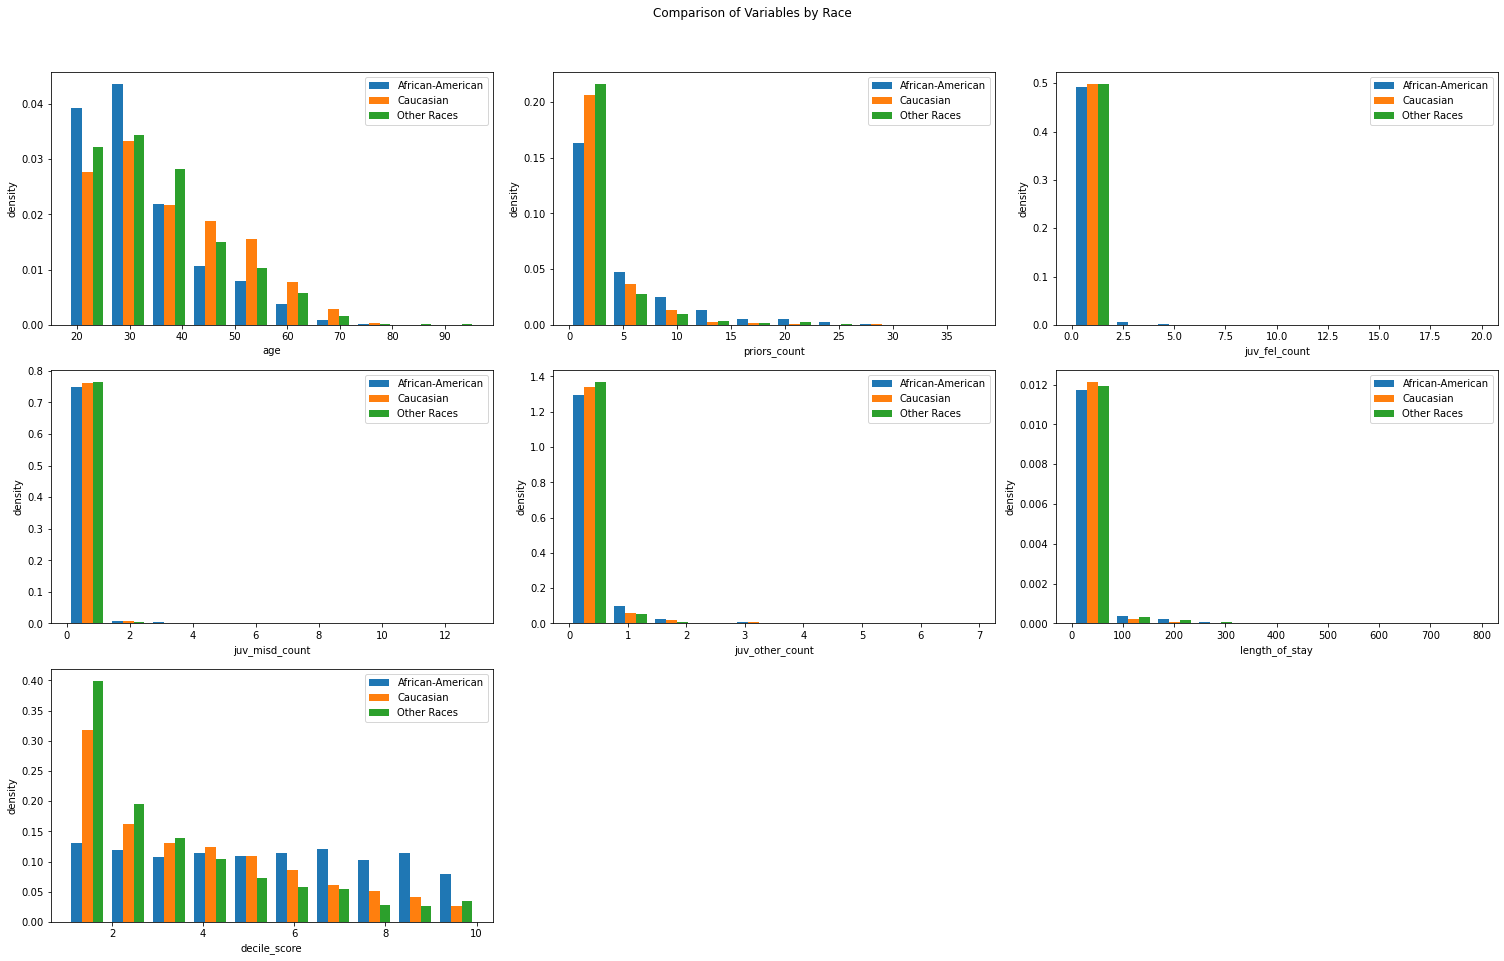

In [10]:
#Your code here
# Plot Histograms
plt.figure(figsize=(21,14))
for i, col in enumerate(unproces_cols):
    plt.subplot(3,3,i+1)
    plt.hist([
        train_df[col].iloc[aa_idx_train],
        train_df[col].iloc[cc_idx_train],
        train_df[col].iloc[non_aa_cc_idx_train],
    ], alpha=1, histtype='bar', density=True, label = ['African-American', 'Caucasian','Other Races',])
    plt.legend()
    plt.xlabel(col)
    plt.ylabel('density')
plt.suptitle('Comparison of Variables by Race')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

*Your interpretation here*

<b>Note:</b> The way you present the data is extemely important in the real world. Plots can induce biases on the obersever so one should be really careful while trying to determine the type of plot what best represents the data

As illustrated by [ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) reporting on the U.S. Criminal Justice system often concentrate on the disparate experiences between Caucasians and African Americans, so let's focus our approaches similarly.

The above EDA plots show significant differences across subjects of different races for the following three variables:
* `age` African-Americans in the dataset skew younger than Caucasians and individuals from other races.
* `priors_count` African-Americans in the dataset have more priors than Caucasians and individual from other races.
* `decile_score` African-Americans in the dataset have a nearly uniform distribution of decile scores, whereas other races have a closer to a poisson distribution of decile scores. As such, African-Americans have a higher decile scores than individuals from other races.

<div class="exercise"><b>Exercise 2.2:</b> The trends observed in the plot above may point to some of the biases present here. Discuss why do the trends seem different for different races? Hint: it points to deeper societal issues and human biases that creep into the data</div>

Given that these data are obtained from the criminal justice system, it's possible that these are biased by the ways that the criminal justice system has historically treated African Americans and Caucasians differently. For eg., the difference in `c_charge_degree` - that a higher percentage of African Americans are charged with felonies than Caucasians - could be related to differences in how people of different races are charged for similar crimes.

Furthermore, differences in `age` and `priors_count` could be influenced by policing practices. If police spend a disproportionate amount of time in African American neighborhoods, this could result in a higher number of priors for African Americans. If police are particularly interested in the activities of young African Americans, as is supported by anecdotal evidence of policing practices, this could lead to the observed difference in the mean/median age among African Americans and Caucasians in the data.

### 3. Fit a logistic regression model to the data

Lets Build a logistic regression model to predict recidivism (`two_year_recid`) from the relevant predictors (including `race`).

In [11]:
# Drop variables in favor of their pre-processed equivalents; also drop decile_score which is the COMPAS output
X_drop = ['priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
          'decile_score', 'two_year_recid', 'length_of_stay', 'length_of_stay_thresh']
X_train, X_test = train_df.drop(columns = X_drop), test_df.drop(columns = X_drop)
y_train, y_test = train_df['two_year_recid'], test_df['two_year_recid']

# Scale data to X_train
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<div class="exercise"><b>Exercise 3.1:</b> Fit a logistic regression model of your choice and print the accuracy score and the model coefficients. What do the coefficients for different races tell you about its realtion to the outcome prediction?</div>

In [12]:
#Your code here
# Fit the model
logit_model = LogisticRegression(penalty="none", solver = "lbfgs", max_iter=1000, random_state=109)
logit_model.fit(X_train_scaled, y_train)

# Print Accuracy score
print('The accuracy score for the logistic regression model on the training data:')
display(logit_model.score(X_train_scaled, y_train))

# Print Coefficients
print('The coefficients for the logistic regression model are:')
display(pd.DataFrame(index=X_train.columns, data={'coefficients': logit_model.coef_[0]}))

The accuracy score for the logistic regression model on the training data:


0.6801701438120316

The coefficients for the logistic regression model are:


,coefficients
age,-3.057583
sex,0.342461
priors_1,0.416671
priors_234,0.961757
priors_5plus,1.776434
juv_fel_1plus,0.221370
juv_misd_1plus,0.065662
juv_other_1plus,0.447106
charge_any_drug,0.283615
charge_any_violence_aggression,0.122322


*Your interpretation here*

The model suggests there is significant variation in recidivism risk for individuals of different races, given coefficients for the racial indicator variables ranging from -0.6666 to 0.3047. For example, consider the odds ratio implied by the `race_African-American` variable:

$$exp(0.3047) \approx 1.356$$

According to the model, the odds of recidivating within 2 years are 1.356 times higher compared to defendants in the `race_Other` group, all other predictors held constant. 

Given our interest in the how the experience of the criminal justice system differs for **Caucasians** and **African-Americans**, consider the difference in odds implied by the coefficients on those two indicator variables.:

$$exp(0.3047 - 0.1981) \approx 1.113$$

According to the model, the odds of an African-American defendant recidivating within 2 years are 1.113 times higher compared to a Caucasian defendant with the same profile. 


In [13]:
# Function to report the FPR and FNR by model
def evaluate_model(model, X_test, y_true, aa_idx, cc_idx, threshold, make_cf = True):
    
    y_pred_proba = model.predict_proba(X_test)[:,1]
    y_pred = np.array([1 if y > threshold else 0 for y in y_pred_proba])
    model_accuracy = accuracy_score(y_pred, y_true)
    
    cf_afam = confusion_matrix(y_true.values[aa_idx], y_pred[aa_idx])
    confusion_afam = dict(zip(['tn','fp','fn','tp'], cf_afam.ravel()))
    
    cf_cau = confusion_matrix(y_true.values[cc_idx], y_pred[cc_idx])
    confusion_caucasian = dict(zip(['tn','fp','fn','tp'], cf_cau.ravel()))
    
    if make_cf == True:
        
        print('Confusion Matrix for African-American:')
        display(pd.DataFrame(cf_afam, 
        index=['true:0', 'true:1'], 
        columns=['pred:0', 'pred:1'] ))

        print('Confusion Matrix for Caucasian:')
        display(pd.DataFrame(cf_cau, 
        index=['true:0', 'true:1'], 
        columns=['pred:0', 'pred:1'] ))
        
    

    fpr_afam = confusion_afam['fp'] / (confusion_afam['fp'] + confusion_afam['tn'])
    fnr_afam = confusion_afam['fn'] / (confusion_afam['fn'] + confusion_afam['tp'])

    fpr_caucasian = confusion_caucasian['fp'] / (confusion_caucasian['fp'] + confusion_caucasian['tn'])
    fnr_caucasian = confusion_caucasian['fn'] / (confusion_caucasian['fn'] + confusion_caucasian['tp'])
    
    with np.errstate(all='raise'):
        try:
            fpr_ratio = fpr_afam/fpr_caucasian
        except:
            fpr_ratio = 0

        try:
            fnr_ratio = fnr_afam/fnr_caucasian
        except:
            fnr_ratio = 0

    return dict(zip(['model_accuracy', 'fpr_afam', 'fnr_afam', 'fpr_caucasian', 'fnr_caucasian','fpr_ratio', 'fnr_ratio'],
                    [model_accuracy, fpr_afam, fnr_afam, fpr_caucasian, fnr_caucasian, fpr_ratio, fnr_ratio]))


In [14]:
# Save the indexes for the two races on the test set
aa_idx_test = np.where(test_df['race_African-American']==1)[0]
cc_idx_test = np.where(test_df['race_Caucasian']==1)[0]

<div class="exercise"><b>Exercise 3.2:</b> The above function is given to you to obtain the confusion matrices for predictions for different races and obtain the relevant rates. Use it for your model and interpret the results</div>

In [15]:
#Your code here
results_df = pd.DataFrame()
results = evaluate_model(logit_model, X_test_scaled, y_test, aa_idx_test, cc_idx_test, 0.5)
results_df = results_df.append(pd.DataFrame(results, index=['logit_model']))
print('The accuracy and error rates for the model on the test set are:')
results_df

Confusion Matrix for African-American:


,pred:0,pred:1
true:0,196,114
true:1,94,231


Confusion Matrix for Caucasian:


,pred:0,pred:1
true:0,211,53
true:1,88,69


The accuracy and error rates for the model on the test set are:


,model_accuracy,fpr_afam,fnr_afam,fpr_caucasian,fnr_caucasian,fpr_ratio,fnr_ratio
logit_model,0.668826,0.367742,0.289231,0.200758,0.56051,1.831771,0.516014


*Your interpretation here*

The model accuracy is only 0.6688, and this seems low given that the model would be in decisions to send people to jail!

There is a significant disparity in the FPR and FNR for the two groups. The false positive rate for African Americans is 1.83 times higher than that for Caucasians, and the false negative rate for African Americans is only about half that for Caucasians. The model misclassifies African Americans in a way that disproportionately flags them as recidivism risks, compared to Caucasians.

### 4. Reducing bais: buiding a Race-Agnostic model

What if race was not included as a factor? Let's refit the logistic model but this time **without** `race` as a predictor. 

<div class="exercise"><b>Exercise 4.1:</b> Drop all columns related to the races and refit the logistic regression model. Again obtain the accuracy score and the model coefficients and compare yor results with those of 3.1 </div>

In [16]:
#Your code here
# Drop the race columns, which are the last 5 columns in the df
X_train_scaled_no_race = X_train_scaled[:, :-5]
X_test_scaled_no_race = X_test_scaled[:, :-5]

# Fit the model
logit_model_no_race = LogisticRegression(penalty="none", solver = "lbfgs", max_iter=1000, random_state=109)
logit_model_no_race.fit(X_train_scaled_no_race, y_train)

# Print Accuracy score
print('The accuracy score for the logistic regression model on the training data:')
display(logit_model_no_race.score(X_train_scaled_no_race, y_train))

# Print Coefficients
print('The coefficients for the logistic regression model excluding race are:')
display(pd.DataFrame(index=X_train.columns[:-5], data={'coefficients': logit_model_no_race.coef_[0]}))

The accuracy score for the logistic regression model on the training data:


0.6815880089122949

The coefficients for the logistic regression model excluding race are:


,coefficients
age,-3.133541
sex,0.335825
priors_1,0.430846
priors_234,0.984869
priors_5plus,1.821295
juv_fel_1plus,0.235103
juv_misd_1plus,0.072473
juv_other_1plus,0.452468
charge_any_drug,0.285638
charge_any_violence_aggression,0.117501


In [17]:
results = evaluate_model(logit_model_no_race, X_test_scaled_no_race, y_test, aa_idx_test, cc_idx_test, 0.5)
results_df = results_df.append(pd.DataFrame(results, index=['logit_model_no_race']))
print('The accuracy and error rates for the model on the test set are:')
results_df

Confusion Matrix for African-American:


,pred:0,pred:1
true:0,206,104
true:1,109,216


Confusion Matrix for Caucasian:


,pred:0,pred:1
true:0,209,55
true:1,86,71


The accuracy and error rates for the model on the test set are:


,model_accuracy,fpr_afam,fnr_afam,fpr_caucasian,fnr_caucasian,fpr_ratio,fnr_ratio
logit_model,0.668826,0.367742,0.289231,0.200758,0.560510,1.831771,0.516014
logit_model_no_race,0.668826,0.335484,0.335385,0.208333,0.547771,1.610323,0.612272


*Your interpretation here*

The accuracy score for the model that does not include the race indicator variables is the same as that for the model that includes the race indicators. However, removing the race indicators resulted in more balanced error rates across the two groups, with a decrease of 0.2 in the fpr_ratio and an increase of 0.1 in the fnr_ratio. Notably, the changes in the false positive and false negative rates for African-Americans were of a greater magnitude than the changes in the rates for Caucasians.

<div class="exercise"><b>Exercise 4.2:</b> Discuss whether such a model be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime? </div>

*Your interpretation here*

Even after removing `race` indicator variables, the model accuracy is still only 67%. This accuracy that is only a little better than a coin flip raises questions as to whether we should use it to decide whether a person who is presumed innocent should be put in jail before being convicted of a crime.

There remains a significant disparity in the FPR and FNR for the two groups. This remains because even though the model no longer includes `race`, it still includes features that are covariates with `race` (e.g., `age` and `priors` as shown in the EDA, as well as the binary indicator `c_charge_degree`, and potentially some of the indicators for `c_charge_desc`, etc.).

This disparity in error rates suggests that African American defendants are penalized by the model - it is more likely to err in the direction of falsely predicting an African-American defendant should be put in jail pending trial. For Caucasians, however, the model is more likely to err by falsely predicting a Caucasian defendant should be released pending trial.

Based on this, one should have serious concerns about using this model to predict (and jail people for) an arrest for some "future" crime, keeping in mind that a major constitutional feature of the U.S. Justice system is the presumption of innocence until proven guilty.

![Minority Report](movie.png)

### Closing thoughts: 
Is algorithmic modeling is appropriate in this use case given the historical biases encoded in the data and the risk of amplifying these historical inequities?

# Bonus Material: Tweaking the decision threshold to make fairer models

Can we reduce bias further by chaning threshold? Lets make an ROC curve for the two subgroups:

In [18]:
plt.rcParams["figure.figsize"] = (10,8)

In [19]:
def make_roc(name, model, ytest, xtest, idx_test, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        
        y_pred = model.predict_proba(xtest)[:,0]
        preds_proba = model.predict_proba(xtest)[:,1]      
       
        auc_score = roc_auc_score(y_test.values[idx_test], preds_proba[idx_test])
        fpr, tpr, thresholds = roc_curve(y_test.values[idx_test], preds_proba[idx_test])
    
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax


sns.set_context("poster")

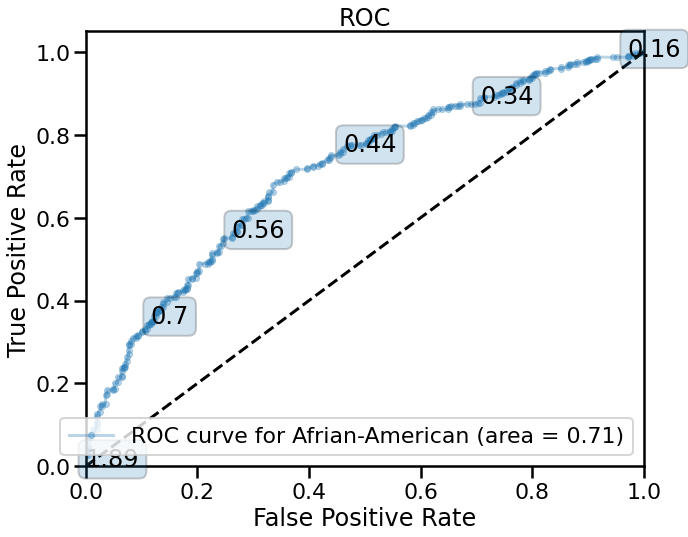

In [20]:
make_roc("Afrian-American", logit_model_no_race, y_test, X_test_scaled_no_race, aa_idx_test, ax=None, labe=60, proba=True, skip=1);

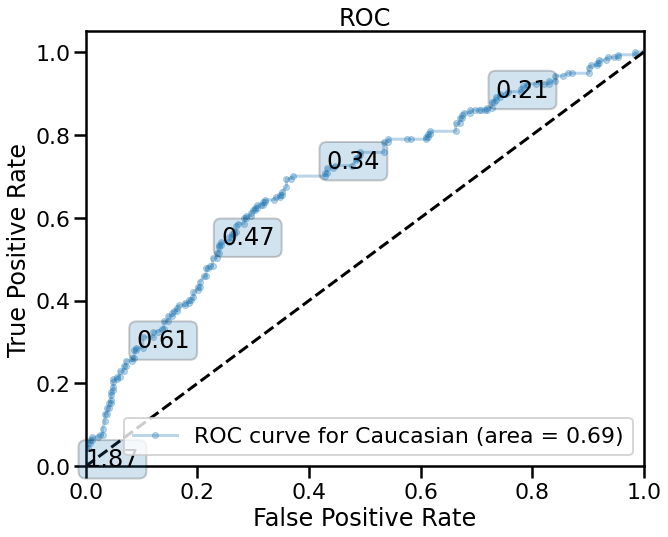

In [21]:
make_roc("Caucasian", logit_model_no_race, y_test, X_test_scaled_no_race, cc_idx_test, ax=None, labe=40, proba=True, skip=1);

<b>1. </b> Lets choose a new single threshold for our model that may will reduce the bias between these two racial groups (as measured by the ratios of FPR and FNR)

In [22]:
results_df = pd.DataFrame()
results = evaluate_model(logit_model_no_race, X_test_scaled_no_race, y_test, aa_idx_test, cc_idx_test, 0.45)
results_df = results_df.append(pd.DataFrame(results, index=['logit_model']))
print('The accuracy and error rates for the model on the test set are:')
results_df

Confusion Matrix for African-American:


,pred:0,pred:1
true:0,171,139
true:1,81,244


Confusion Matrix for Caucasian:


,pred:0,pred:1
true:0,193,71
true:1,67,90


The accuracy and error rates for the model on the test set are:


,model_accuracy,fpr_afam,fnr_afam,fpr_caucasian,fnr_caucasian,fpr_ratio,fnr_ratio
logit_model,0.668826,0.448387,0.249231,0.268939,0.426752,1.667242,0.584018


It doesnt seem to improve, maybe there's a optimal threshold?

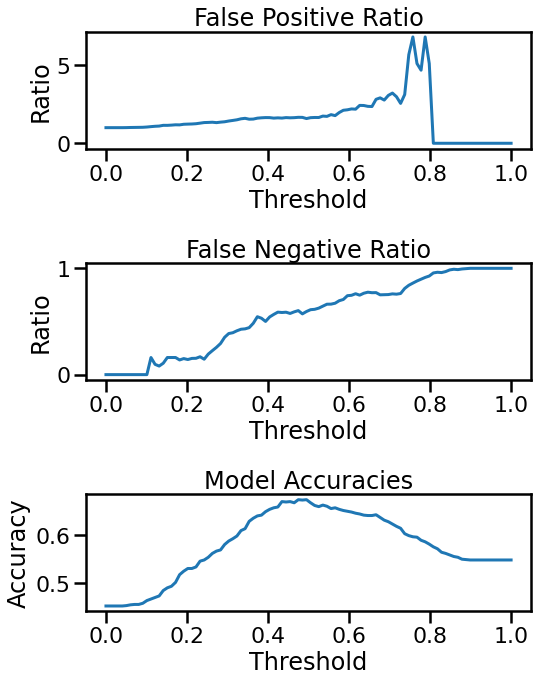

In [23]:
t_vals = np.linspace(0,1,100)
fpr_ratios = []
fnr_ratios = []
accuracies = []
for t in t_vals:
    result = evaluate_model(logit_model_no_race, X_test_scaled_no_race, y_test, aa_idx_test, cc_idx_test, threshold=t, make_cf = False)
    fpr_ratios.append(result['fpr_ratio'])
    fnr_ratios.append(result['fnr_ratio'])
    accuracies.append(result['model_accuracy'])

plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
plt.plot(t_vals,fpr_ratios)
plt.title("False Positive Ratio")
plt.xlabel("Threshold")
plt.ylabel("Ratio")

plt.subplot(3,1,2)
plt.plot(t_vals,fnr_ratios)
plt.title("False Negative Ratio")
plt.xlabel("Threshold")
plt.ylabel("Ratio")

plt.subplot(3,1,3)
plt.plot(t_vals,accuracies)
plt.title("Model Accuracies")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

From the above graphs, a threshold around .8 could be good since the FNR ratio is nearly 1 while the FPR ratio dips close to 1. In practice, this still means we are accepting that a higher ratio of African Americans will be wrongly classified as "high risk". A selection that brings FPR ratio to 1 will run into the opposite problem where we have to accept a FNR ratio that is further from 1.

Selecting on model accuracy alone is not a great answer since it ignores the fact that False Negative and Positive ratios remain poor. We should make sure the model accuracy doesn't dip too close to .5 as that means we are essentially doing a coin toss.

--------------------------

<b>2. </b> Another approach to reducing bias is to use different thresholds for the different racial groups to better ensure that the groups have similar false positive and false negative rates.

In [24]:
# Lets separate datset by race
X_test_scaled_no_race_aa = X_test_scaled_no_race[aa_idx_test]
X_test_scaled_no_race_cc = X_test_scaled_no_race[cc_idx_test]
y_test_aa = np.array(y_test)[aa_idx_test]
y_test_cc = np.array(y_test)[cc_idx_test]

In [25]:
# Getting FPR, FNR, and accuracy by threshold for both datasets
fpr_aa = []
fnr_aa = []
accuracy_aa = []
fpr_cc = []
fnr_cc = []
accuracy_cc = []
for threshold in t_vals:
    # Get values for AA dataset
    y_pred_proba = logit_model_no_race.predict_proba(X_test_scaled_no_race_aa)[:,1]
    y_preds = np.array([1 if y > threshold else 0 for y in y_pred_proba])
    accuracy_aa.append(accuracy_score(y_preds, y_test_aa))
    confusion_afam = dict(zip(['tn','fp','fn','tp'], confusion_matrix(y_test_aa, y_preds).ravel()))
    fpr_aa.append(confusion_afam['fp'] / (confusion_afam['fp'] + confusion_afam['tn']))
    fnr_aa.append(confusion_afam['fn'] / (confusion_afam['fn'] + confusion_afam['tp']))

    # Get values for CC dataset
    y_pred_proba = logit_model_no_race.predict_proba(X_test_scaled_no_race_cc)[:,1]
    y_preds = np.array([1 if y > threshold else 0 for y in y_pred_proba])
    accuracy_cc.append(accuracy_score(y_preds, y_test_cc))
    confusion_caucasian = dict(zip(['tn','fp','fn','tp'], confusion_matrix(y_test_cc, y_preds).ravel()))
    fpr_cc.append(confusion_caucasian['fp'] / (confusion_caucasian['fp'] + confusion_caucasian['tn']))
    fnr_cc.append(confusion_caucasian['fn'] / (confusion_caucasian['fn'] + confusion_caucasian['tp']))

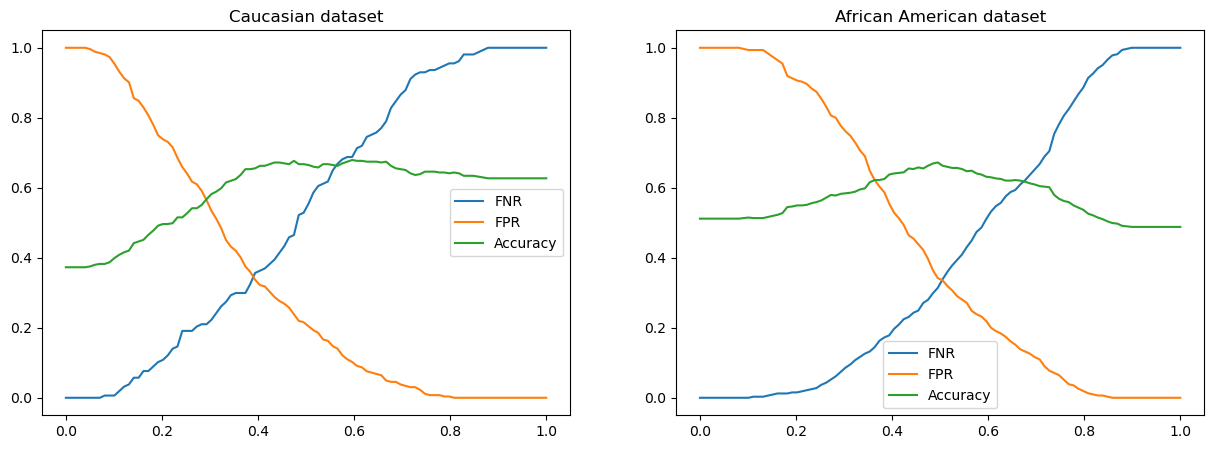

In [26]:
plt.style.use('default')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(t_vals,fnr_cc,label='FNR')
plt.plot(t_vals,fpr_cc,label='FPR')
plt.plot(t_vals,accuracy_cc,label='Accuracy')
plt.title('Caucasian dataset')
plt.legend()

plt.subplot(1,2,2)
plt.plot(t_vals,fnr_aa,label='FNR')
plt.plot(t_vals,fpr_aa,label='FPR')
plt.plot(t_vals,accuracy_aa,label='Accuracy')
plt.title('African American dataset')
plt.legend()
plt.show()

In [27]:
print("Caucasian numbers w/threshold=.4")
print("FPR = ",fpr_cc[40])
print("FNR = ",fnr_cc[40])
print("Accuracy = ",accuracy_cc[40])

Caucasian numbers w/threshold=.4
FPR =  0.32196969696969696
FNR =  0.3630573248407643
Accuracy =  0.66270783847981


In [28]:
print("African American numbers w/threshold=.5")
print("FPR = ",fpr_aa[50])
print("FNR = ",fpr_aa[50])
print("Accuracy = ",accuracy_aa[50])

African American numbers w/threshold=.5
FPR =  0.33548387096774196
FNR =  0.33548387096774196
Accuracy =  0.662992125984252


From these graphs, a threshold around .4 for Caucasians and around .5 for African Americans seems to provide equitable treatment while maintaining good accuracy rates. Model accuracy was .66 in both which was near the peak. The False Positive and False Negative rates were also very similar for both groups, hovering around .33.

#### Comparing the fairness of the above two methods:
A model satifies group fairness if the subjects in both race groups have equal probability of being assigned to the positive class. Individual fairness is achieved if two individuals with equal characteristics aside from their race have equal probability of being assigned to the positive class.

The model with fixed threshold across subgroups (<b>4.1</b>) does not quite achieve group fairness as the ratios of FPR and FNR between the two groups is not quite 1. However, it does maintain individual fairness by not changing the threshold depending on the subject's race. The model with different thresholds for each subgroups (<b>4.2</b>) achieves group fairness since the groups as a whole are equally classified. However, since the thresholds change based on the individual's race, it may not be individually fair (if we assume that the predictors capture all of the relevant information about what qualifies someone to be a recidivism risk).

Changing the thresholds can *reduce* bias between the two classes, but it can also affect model accuracy. We want our model to be **accurate** but also **fair**. 

## HW: Try different approaches introduced in the class to see if you can make a better performing fair model with higher accuracy